In [9]:
!pip install pydoe

  Created wheel for pydoe: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=c1af848d0123826a49bb93bccc8f3e02a096a596d1e55a620905015b5f805b16
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pydoe


In [19]:
import numpy as np
from scipy.special import gamma
from scipy.special import jacobi
from scipy.special import roots_jacobi

#from scipy.special import legendre
#import matplotlib.pyplot as plt

##################################################################
# Recursive generation of the Jacobi polynomial of order n
def Jacobi(n,a,b,x):
    x=np.array(x)
    return (jacobi(n,a,b)(x))
    
##################################################################
# Derivative of the Jacobi polynomials
def DJacobi(n,a,b,x,k: int):
    x=np.array(x)
    ctemp = gamma(a+b+n+1+k)/(2**k)/gamma(a+b+n+1)
    return (ctemp*Jacobi(n-k,a+k,b+k,x))

    
##################################################################
# Weight coefficients
def GaussJacobiWeights(Q: int,a,b):
    [X , W] = roots_jacobi(Q,a,b)
    return [X, W]
	


##################################################################
# Weight coefficients
def GaussLobattoJacobiWeights(Q: int,a,b):
    W = []
    X = roots_jacobi(Q-2,a+1,b+1)[0]
    if a == 0 and b==0:
        W = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,X)**2) )
        Wl = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,-1)**2) )
        Wr = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,1)**2) )
    else:
        W = 2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,X)**2) )
        Wl = (b+1)*2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,-1)**2) )
        Wr = (a+1)*2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,1)**2) )
    W = np.append(W , Wr)
    W = np.append(Wl , W)
    X = np.append(X , 1)
    X = np.append(-1 , X)    
    return [X, W]
##################################################################


    

Tensor("Placeholder_6:0", shape=(?, 1), dtype=float64)
It: 0, Lossb: 9.972e+03, Lossv: 3.111e-04, Time: 1.41
It: 100, Lossb: 8.883e+03, Lossv: 2.249e+01, Time: 0.71
It: 200, Lossb: 8.461e+03, Lossv: 4.680e+01, Time: 0.72
It: 300, Lossb: 8.085e+03, Lossv: 6.332e+01, Time: 0.75
It: 400, Lossb: 7.736e+03, Lossv: 6.839e+01, Time: 0.73
It: 500, Lossb: 7.407e+03, Lossv: 6.687e+01, Time: 0.72
It: 600, Lossb: 7.097e+03, Lossv: 6.376e+01, Time: 0.72
It: 700, Lossb: 6.803e+03, Lossv: 6.099e+01, Time: 0.73
It: 800, Lossb: 6.524e+03, Lossv: 5.837e+01, Time: 0.72
It: 900, Lossb: 6.258e+03, Lossv: 5.411e+01, Time: 0.70
It: 1000, Lossb: 6.006e+03, Lossv: 4.365e+01, Time: 0.75
It: 1100, Lossb: 5.764e+03, Lossv: 2.395e+01, Time: 0.73
It: 1200, Lossb: 5.533e+03, Lossv: 3.000e+01, Time: 0.72
It: 1300, Lossb: 5.312e+03, Lossv: 3.708e+01, Time: 0.71
It: 1400, Lossb: 5.101e+03, Lossv: 4.253e+01, Time: 0.73
It: 1500, Lossb: 4.900e+03, Lossv: 4.750e+01, Time: 0.72
It: 1600, Lossb: 4.707e+03, Lossv: 4.962e+01,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:422: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


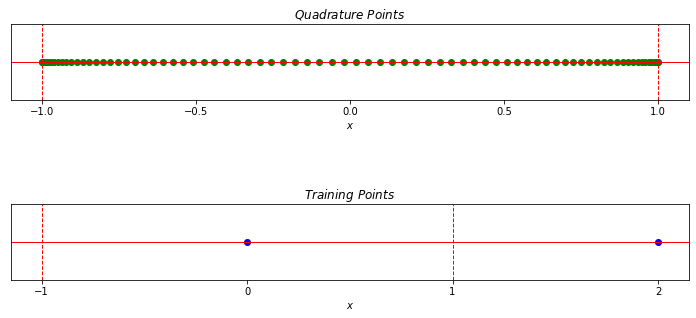

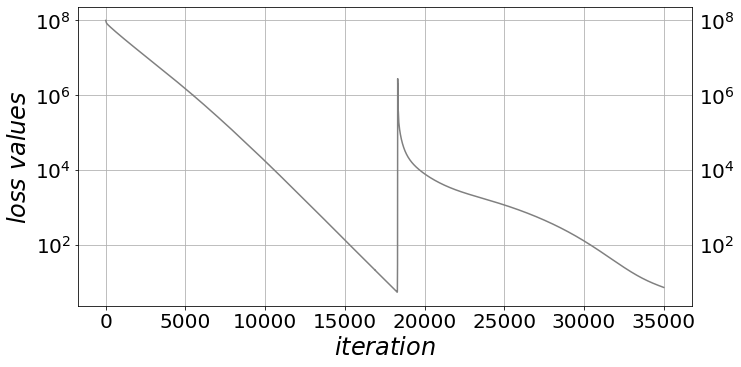

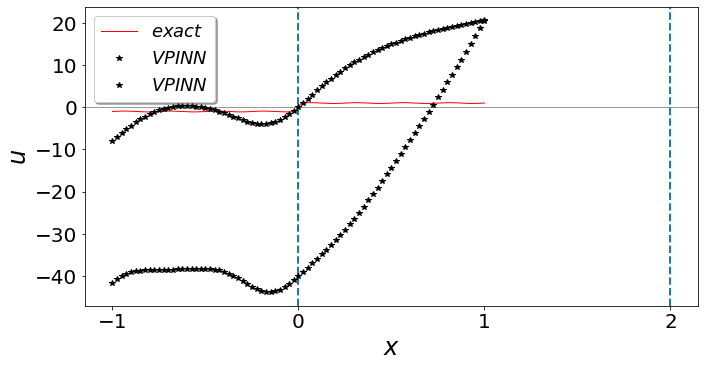

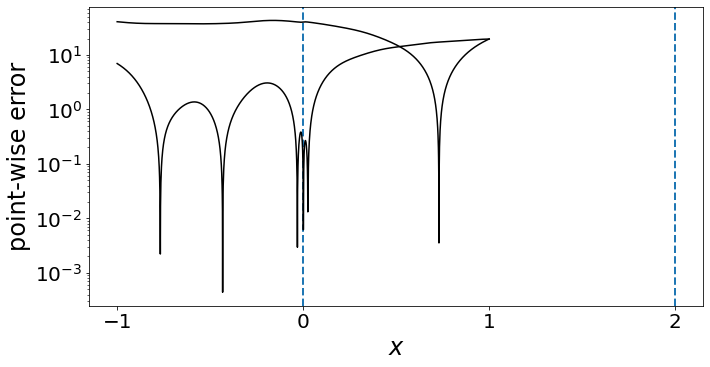

In [20]:
###############################################################################

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pyDOE import lhs
#from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time

np.random.seed(1234)
tf.set_random_seed(1234)

###############################################################################
class VPINN:
    def __init__(self, X_u_train, u_train, X_quad, W_quad, F_exact_total,\
                 grid, X_test, u_test, layers, X_f_train, f_train):

        self.x       = X_u_train
        self.u       = u_train
        self.xf      = X_f_train
        self.f      = f_train
        self.xquad   = X_quad
        self.wquad   = W_quad
        self.xtest   = X_test
        self.utest   = u_test
        self.F_ext_total = F_exact_total
        self.Nelement = np.shape(self.F_ext_total)[0]
        self.N_test   = np.shape(self.F_ext_total[0])[0]
        
        self.x_tf   = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.u_tf   = tf.placeholder(tf.float64, shape=[None, self.u.shape[1]])
        self.xf_tf   = tf.placeholder(tf.float64, shape=[None, self.xf.shape[1]])
        self.f_tf   = tf.placeholder(tf.float64, shape=[None, self.f.shape[1]])
        self.x_test = tf.placeholder(tf.float64, shape=[None, self.xtest.shape[1]])
        self.x_quad = tf.placeholder(tf.float64, shape=[None, self.xquad.shape[1]])
      
        self.weights, self.biases, self.a = self.initialize_NN(layers)

        self.u_NN_quad  = self.net_u(self.x_quad)
        self.d1u_NN_quad, self.d2u_NN_quad = self.net_du(self.x_quad)
        self.test_quad   = self.Test_fcn(self.N_test, self.xquad)
        self.d1test_quad, self.d2test_quad = self.dTest_fcn(self.N_test, self.xquad)
        
        self.u_NN_pred   = self.net_u(self.x_tf)
        print(self.x_tf)
        self.u_NN_test   = self.net_u(self.x_test)
        self.f_pred = self.net_f(self.x_test)
        
        self.varloss_total = 0
        for e in range(self.Nelement):
            F_ext_element  = self.F_ext_total[e]
            Ntest_element  = np.shape(F_ext_element)[0]
            
            x_quad_element = tf.constant(grid[e] + (grid[e+1]-grid[e])/2*(self.xquad+1))
            x_b_element    = tf.constant(np.array([[grid[e]], [grid[e+1]]]))
            jacobian       = (grid[e+1]-grid[e])/2

            test_quad_element = self.Test_fcn(Ntest_element, self.xquad)
            d1test_quad_element, d2test_quad_element = self.dTest_fcn(Ntest_element, self.xquad)
            u_NN_quad_element = self.net_u(x_quad_element)
            d1u_NN_quad_element, d2u_NN_quad_element = self.net_du(x_quad_element)

            u_NN_bound_element = self.net_u(x_b_element)
            d1test_bound_element, d2test_bounda_element = self.dTest_fcn(Ntest_element, np.array([[0],[2]]))


            if var_form == 1:
                U_NN_element = tf.reshape(tf.stack([-jacobian*tf.reduce_sum(self.wquad*d2u_NN_quad_element*test_quad_element[i]) \
                                                   for i in range(Ntest_element)]),(-1,1))
            if var_form == 2:
                U_NN_element = tf.reshape(tf.stack([ tf.reduce_sum(self.wquad*d1u_NN_quad_element*d1test_quad_element[i]) \
                                                    for i in range(Ntest_element)]),(-1,1))
            if var_form == 3:
                U_NN_element = tf.reshape(tf.stack([-1/jacobian*tf.reduce_sum(self.wquad*u_NN_quad_element*d2test_quad_element[i]) \
                                                   +1/jacobian*tf.reduce_sum(u_NN_bound_element*np.array([-d1test_bound_element[i][0], d1test_bound_element[i][-1]]))  \
                                                   for i in range(Ntest_element)]),(-1,1))
                

            Res_NN_element = U_NN_element - F_ext_element*0
            loss_element = tf.reduce_mean(tf.square(Res_NN_element))
            self.varloss_total = self.varloss_total + loss_element
        
        self.lossb = tf.reduce_mean(tf.square(0 - self.net_u(np.array([[0]],dtype=np.float64))[0][0]))+ tf.reduce_mean(tf.square(100 - self.net_u(np.array([[2]],dtype=np.float64))[0][1]))+tf.reduce_mean(tf.square( self.net_u(np.array([[1]],dtype=np.float64))[0][0]-self.net_u(np.array([[1]],dtype=np.float64))[0][1]))
        
        self.loss2=tf.reduce_mean(self.interface(x_quad_element),0)
        
        
        self.lossv = self.varloss_total
        self.loss  = 1*self.lossb**2 + (1*self.lossv**2)+self.loss2**2
        
        self.LR = LR
        self.optimizer_Adam = tf.train.AdamOptimizer(self.LR)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        self.sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)

###############################################################################
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            a = tf.Variable(0.01, dtype=tf.float64)
            weights.append(W)
            biases.append(b)        
        return weights, biases, a
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim), dtype=np.float64)
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev,dtype=tf.float64), dtype=tf.float64)
 
    def neural_net(self, X, weights, biases, a):
        num_layers = len(weights) + 1
        H = X 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x):  
        u = self.neural_net(tf.concat([x],1), self.weights, self.biases, self.a)
        return u

    def net_du(self, x):
        u   = self.net_u(x)
        d1u = tf.gradients(u, x)[0]
        d2u = tf.gradients(d1u, x)[0]
        return d1u, d2u

    def net_f(self, x):
        
        u = self.net_u(x)
       
        u_x = tf.gradients(u, x)
       
        u_x = tf.gradients(u, x)[0]
        
        u_xx = tf.gradients(u_x, x)[0]
        f = - u_xx
        return f
    def interface(self,x):
        u = self.net_u(x)
        u_x1= tf.gradients(u[:,0], x)[0]
        u_x2=tf.gradients(u[:,1], x)[0]
        
        int_loss=(u_x1[39]-.1*u_x2[40])
        return int_loss
     

    def Test_fcn(self, N_test,x):
        test_total = []
        for n in range(1,N_test+1):
            test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
            test_total.append(test)
        return np.asarray(test_total)

    def dTest_fcn(self, N_test,x):
        d1test_total = []
        d2test_total = []
        for n in range(1,N_test+1):
            if n==1:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n==2:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
            else:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x) - ((n)*(n+1)/(2*2))*Jacobi(n-3,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
        return np.asarray(d1test_total), np.asarray(d2test_total)

    def predict_subdomain(self, grid):
        error_u_total = []
        u_pred_total = []
        for e in range(self.Nelement):
            utest_element = self.utest_total[e]
            x_test_element = grid[e] + (grid[e+1]-grid[e])/2*(self.xtest+1)
            u_pred_element = self.sess.run(self.u_NN_test, {self.x_test: x_test_element})
            error_u_element = np.linalg.norm(utest_element - u_pred_element,2)/np.linalg.norm(utest_element,2)
            error_u_total.append(error_u_element)
            u_pred_total.append(u_pred_element)
        return u_pred_total, error_u_total

    def predict(self, x):
        u_pred  = self.sess.run(self.u_NN_test, {self.x_test: x})
        return u_pred        

    def train(self, nIter, tresh):
        
        tf_dict = {self.x_tf: self.x, self.u_tf: self.u,\
                   self.x_quad: self.xquad, self.x_test: self.xtest,\
                   self.xf_tf: self.xf, self.f_tf: self.f}
        start_time       = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
 
            if it % 10 == 0:
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_valueb= self.sess.run(self.lossb, tf_dict)
                loss_valuev= self.sess.run(self.lossv, tf_dict)
                total_record.append(np.array([it, loss_value]))
                
                if loss_value < tresh:
                    print('It: %d, Loss: %.3e' % (it, loss_value))
                    break
                
            if it % 100 == 0:
                elapsed = time.time() - start_time
                str_print = 'It: %d, Lossb: %.3e, Lossv: %.3e, Time: %.2f'
                print(str_print % (it, loss_valueb, loss_valuev, elapsed))
                start_time = time.time()


if __name__ == "__main__": 

    
    #++++++++++++++++++++++++++++
    LR = 0.001
    Opt_Niter = 35000 + 1
    Opt_tresh = 2e-32
    var_form  = 1
    N_Element = 1
    Net_layer = [1] + [20] * 8 + [2] 
    N_testfcn = 60
    N_Quad = 80
    N_F = 500  
    lossb_weight = 1
        
    #++++++++++++++++++++++++++++    
    def Test_fcn(n,x):
       test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
       return test

    #++++++++++++++++++++++++++++    
    omega = 8*np.pi
    amp = 1
    r1 = 80
    def u_ext(x):
        utemp = 0.1*np.sin(omega*x) + np.tanh(r1*x)
        return amp*utemp

    def f_ext(x):
        gtemp =  -0.1*(omega**2)*np.sin(omega*x) - (2*r1**2)*(np.tanh(r1*x))/((np.cosh(r1*x))**2)
        return -amp*gtemp*0

    #++++++++++++++++++++++++++++
    NQ_u = N_Quad
    [x_quad, w_quad] = GaussLobattoJacobiWeights(NQ_u, 0, 0)
    testfcn = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn+1)])
    
    NE = N_Element
    [x_l, x_r] = [0, 2]
    delta_x = (x_r - x_l)/NE
    grid = np.asarray([ x_l + i*delta_x for i in range(NE+1)])
    N_testfcn_total = np.array((len(grid)-1)*[N_testfcn])
 
    if N_Element == 3:
        grid = np.array([0, -0.1, 0.1, 2])
        NE = len(grid)-1
        N_testfcn_total = np.array([N_testfcn,N_testfcn,N_testfcn])
    
    U_ext_total = []
    F_ext_total = []
    for e in range(NE):
        x_quad_element = grid[e] + (grid[e+1]-grid[e])/2*(x_quad+1)
        jacobian = (grid[e+1]-grid[e])/2
        N_testfcn_temp = N_testfcn_total[e]
        testfcn_element = np.asarray([ Test_fcn(n,x_quad)  for n in range(1, N_testfcn_temp+1)])

        u_quad_element = u_ext(x_quad_element)
        U_ext_element  = jacobian*np.asarray([sum(w_quad*u_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
        U_ext_element = U_ext_element[:,None]
        U_ext_total.append(U_ext_element)

        f_quad_element = f_ext(x_quad_element)
        F_ext_element  = jacobian*np.asarray([sum(w_quad*f_quad_element*testfcn_element[i]) for i in range(N_testfcn_temp)])
        F_ext_element = F_ext_element[:,None]
        F_ext_total.append(F_ext_element)
    
    U_ext_total = np.asarray(U_ext_total)
    F_ext_total = np.asarray(F_ext_total)

    #++++++++++++++++++++++++++++
    # Training points
    X_u_train = np.asarray([0.0,2.0])[:,None]
    #u_train   = u_ext(X_u_train)
    u_train=np.array([[0],[100]])
    X_bound = np.asarray([0.0,2])[:,None]
    
    Nf = N_F
    X_f_train = (2*lhs(1,Nf)-0)
    f_train   = f_ext(X_f_train)

    #++++++++++++++++++++++++++++
    # Quadrature points
    [x_quad, w_quad] = GaussLobattoJacobiWeights(N_Quad, 0, 0)

    X_quad_train = x_quad[:,None]
    W_quad_train = w_quad[:,None]

    #++++++++++++++++++++++++++++
    # Test point
    delta_test = 0.001
    xtest      = np.arange(-1 , 1 + delta_test , delta_test)
    data_temp  = np.asarray([ [xtest[i],u_ext(xtest[i])] for i in range(len(xtest))])
    X_test = data_temp.flatten()[0::2]
    u_test = data_temp.flatten()[1::2]
    X_test = X_test[:,None]
    u_test = u_test[:,None]
    f_test = f_ext(X_test)

    u_test_total = []
    for e in range(NE):
        x_test_element = grid[e] + (grid[e+1]-grid[e])/2*(xtest+1)
        u_test_element = u_ext(x_test_element)
        u_test_element = u_test_element[:,None]
        u_test_total.append(u_test_element)

    #++++++++++++++++++++++++++++
    # Model and Training
    model = VPINN(X_u_train, u_train, X_quad_train, W_quad_train, F_ext_total,\
                  grid, X_test, u_test, Net_layer, X_f_train, f_train)
    total_record = []
    model.train(Opt_Niter, Opt_tresh)
    u_pred = model.predict(X_test)

    # =========================================================================
    #     Plotting
    # =========================================================================    
    x_quad_plot = X_quad_train
    y_quad_plot = np.empty(len(x_quad_plot))
    y_quad_plot.fill(1)
    
    x_train_plot = X_u_train
    y_train_plot = np.empty(len(x_train_plot))
    y_train_plot.fill(1) 
    
    x_f_plot = X_f_train
    y_f_plot = np.empty(len(x_f_plot))
    y_f_plot.fill(1)
    
    fig = plt.figure(0)
    gridspec.GridSpec(3,1)
    
    plt.subplot2grid((3,1), (0,0))
    plt.tight_layout()
    plt.locator_params(axis='x', nbins=6)
    plt.yticks([])
    plt.title('$Quadrature \,\, Points$')
    plt.xlabel('$x$')
    plt.axhline(1, linewidth=1, linestyle='-', color='red')
    plt.axvline(-1, linewidth=1, linestyle='--', color='red')
    plt.axvline(1, linewidth=1, linestyle='--', color='red')
    plt.scatter(x_quad_plot,y_quad_plot, color='green')
    
    plt.subplot2grid((3,1), (1,0))
    plt.tight_layout()
    plt.locator_params(axis='x', nbins=6)
    plt.yticks([])
    plt.title('$Training \,\, Points$')
    plt.xlabel('$x$')
    plt.axhline(1, linewidth=1, linestyle='-', color='red')
    plt.axvline(-1, linewidth=1, linestyle='--', color='red')
    plt.axvline(1, linewidth=1, linestyle='--', color='red')
    plt.scatter(x_train_plot,y_train_plot, color='blue')

    fig.tight_layout()
    fig.set_size_inches(w=10,h=7)
        
    #++++++++++++++++++++++++++++

    font = 24

    fig, ax = plt.subplots()
    plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
    plt.xlabel('$iteration$', fontsize = font)
    plt.ylabel('$loss \,\, values$', fontsize = font)
    plt.yscale('log')
    plt.grid(True)
    iteration = [total_record[i][0] for i in range(len(total_record))]
    loss_his  = [total_record[i][1] for i in range(len(total_record))]
    plt.plot(iteration, loss_his, 'gray')
    plt.tick_params( labelsize = 20)
    fig.set_size_inches(w=11,h=5.5)
    #plt.savefig('Results/loss.pdf')
    #++++++++++++++++++++++++++++

    pnt_skip = 25
    fig, ax = plt.subplots()
    plt.locator_params(axis='x', nbins=6)
    plt.locator_params(axis='y', nbins=8)
    plt.xlabel('$x$', fontsize = font)
    plt.ylabel('$u$', fontsize = font)
    plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
    for xc in grid:
        plt.axvline(x=xc, linewidth=2, ls = '--')
    plt.plot(X_test, u_test, linewidth=1, color='r', label=''.join(['$exact$']))
    plt.plot(X_test[0::pnt_skip], u_pred[0::pnt_skip], 'k*', label='$VPINN$')
    plt.tick_params( labelsize = 20)
    legend = plt.legend(shadow=True, loc='upper left', fontsize=18, ncol = 1)
    fig.set_size_inches(w=11,h=5.5)
    #plt.savefig('Results/prediction.pdf')
    #++++++++++++++++++++++++++++

    fig, ax = plt.subplots()
    plt.locator_params(axis='x', nbins=6)
    plt.locator_params(axis='y', nbins=8)
    plt.xlabel('$x$', fontsize = font)
    plt.ylabel('point-wise error', fontsize = font)
    plt.yscale('log')
    plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
    for xc in grid:
        plt.axvline(x=xc, linewidth=2, ls = '--')
    plt.plot(X_test, abs(u_test - u_pred), 'k')
    plt.tick_params( labelsize = 20)
    fig.set_size_inches(w=11,h=5.5)
   # plt.savefig('Results/error.pdf')
    #++++++++++++++++++++++++++++



    




In [21]:
xx=np.linspace(0,2,1000)
collect=[]
for elem in xx:
    
    res=model.predict([[elem]])
    #res=res.reshape(1)
    collect.append(res)

In [22]:
collect

[array([[  0.05115441, -40.1109933 ]]),
 array([[  0.12607913, -40.03018645]]),
 array([[  0.20136654, -39.94906818]]),
 array([[  0.27700398, -39.86765551]]),
 array([[  0.35297877, -39.78596508]]),
 array([[  0.42927825, -39.70401313]]),
 array([[  0.50588977, -39.6218155 ]]),
 array([[  0.58280071, -39.53938759]]),
 array([[  0.65999849, -39.4567444 ]]),
 array([[  0.73747056, -39.37390046]]),
 array([[  0.81520442, -39.29086985]]),
 array([[  0.89318761, -39.2076662 ]]),
 array([[  0.97140776, -39.12430265]]),
 array([[  1.04985253, -39.04079189]]),
 array([[  1.12850968, -38.95714608]]),
 array([[  1.20736702, -38.87337692]]),
 array([[  1.28641246, -38.7894956 ]]),
 array([[  1.36563401, -38.7055128 ]]),
 array([[  1.44501976, -38.62143869]]),
 array([[  1.52455789, -38.53728292]]),
 array([[  1.60423672, -38.45305465]]),
 array([[  1.68404466, -38.36876249]]),
 array([[  1.76397022, -38.28441454]]),
 array([[  1.84400208, -38.20001839]]),
 array([[  1.92412899, -38.11558111]]),


In [23]:
xp=np.linspace(0,2,1000)
collect=[]
for elem in xp[:501]:
    ok=model.predict([[elem]])[0][0]
    #ok=ok.cpu().detach().numpy()
    collect.append(ok)
for elem in xp[501:]:
    ok=model.predict([[elem]])[0][1]
    #ok=ok.cpu().detach().numpy()
    collect.append(ok)

In [24]:
collect

[0.0511544131951962,
 0.12607912827727885,
 0.20136654491489603,
 0.2770039847529886,
 0.3529787737889265,
 0.4292782494502583,
 0.5058897676184166,
 0.5828007095891508,
 0.6599984889605945,
 0.7374705584404211,
 0.815204416562965,
 0.8931876143083617,
 0.9714077616155987,
 1.04985253378119,
 1.1285096777363228,
 1.2073670181950358,
 1.2864124636664154,
 1.3656340123242714,
 1.445019757728136,
 1.524557894389274,
 1.604236723176676,
 1.6840446565572518,
 1.7639702236660284,
 1.8440020752013804,
 1.9241289881416037,
 2.004339870279137,
 2.084623764569007,
 2.1649698532887305,
 2.2453674620073816,
 2.3258060633614894,
 2.40627528063614,
 2.486764891150151,
 2.5672648294441225,
 2.647765190270902,
 2.7282562313886523,
 2.8087283761558077,
 2.889172215929353,
 2.9695785122668092,
 3.049938198932856,
 3.130242383712914,
 3.2104823500344697,
 3.290649558398936,
 3.37073564762614,
 3.450732435913994,
 3.5306319217165063,
 3.610426284443,
 3.6901078849817743,
 3.769669266052292,
 3.84910315238

In [25]:
model.predict(np.array([[1]]))[0]

array([20.55319072, 20.61742986])

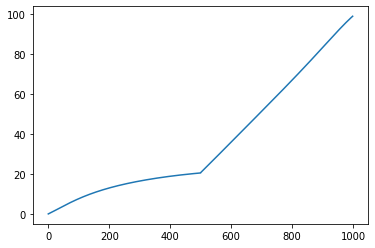

In [26]:
plt.plot(collect)

In [27]:
model.predict(np.array([[2]]))


array([[23.01850597, 98.99633344]])